In [106]:
#Imports
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm

In [16]:
#Data loading 

#usefull_columns = ['genres','keywords','popularity']
#TO BE REMOVED to let the user give the array as a parameter of the function. 
Movies = pd.read_csv("../../Datasets/Transformed.csv",usecols=usefull_columns)

#We reduce the dataframe size with only the usefull column to earn some computation time.

In [116]:
#Constant definition

#Cost added if the first genre is similar between two films
first_genre = 5
#Cost added if the secondary genre is similar between two films
second_genre = 1
#Cost added by similar keyword identical between two films
keyword_cost = 1

In [29]:
def cost_function():
    """Define the cost between the film given in index and the others one."""
    costs = np.zeros([Movies.shape[0],Movies.shape[0]])
    
    for i in tqdm(range(Movies.shape[0])):
        current_film = Movies.iloc[i]
        genres_current = get_genres(current_film)
        kw_current = get_keywords(current_film)
        popularity_current = current_film['popularity']

        for j in range(i,Movies.shape[0]):
            cost = 0

            b_film = Movies.iloc[j]
            genres_b = get_genres(b_film)
            popularity_b = b_film['popularity']
            #First we only select the first genre to determine the similarity because it's more important that the other genre.
            if len(genres_current) > 0  & len(genres_b) > 0:
                if (genres_current[0] == genres_b[0]):
                    cost += first_genre

                #This give us the number of similar genres. We pop the first one because we already compare them.
                cost += np.sum(np.in1d(genres_current,genres_b.pop(0),assume_unique='True')) * second_genre


            kw_b = get_keywords(b_film)
            #This give us the number of similar keywords.
            cost += np.sum(np.in1d(kw_current,kw_b,assume_unique='True')) * keyword_cost
            
            
            #impossible here because we ignore to much popularity
            #cost = (cost * popularity_b/100) / (popularity_current/100)
            costs[i,j] = cost
            costs[j,i] = cost
            
            
    return costs

def get_genres(film):
    genres = str(film['genres'])
    if genres == 'nan':
        return[]
    else:
        genres = genres.split(",")
    return genres

def get_keywords(film):
    kw = str(film['keywords'])
    if kw == 'nan':
        return[]
    else:
        kw = kw.split(",")
    return kw

In [30]:
costs = cost_function()

#Save the costs
#np.savez_compressed("../../Datasets/costs.npz", costs, delimiter=",")
print(costs)

100%|██████████| 4809/4809 [56:50<00:00,  1.41it/s]  

[[  0.   0.   0. ...,   0.   0.   0.]
 [  0.  17.   0. ...,   0.   0.   0.]
 [  0.   0.   8. ...,   0.   0.   0.]
 ..., 
 [  0.   0.   0. ...,  10.   0.   0.]
 [  0.   0.   0. ...,   0.  11.   0.]
 [  0.   0.   0. ...,   0.   0.  16.]]


In [32]:
np.savez_compressed("../../Datasets/costs.npz", costs, costs = costs)

In [34]:
costs = np.load('../../Datasets/costs.npz')
costs = costs['costs']

[[  0.   0.   0. ...,   0.   0.   0.]
 [  0.  17.   0. ...,   0.   0.   0.]
 [  0.   0.   8. ...,   0.   0.   0.]
 ..., 
 [  0.   0.   0. ...,  10.   0.   0.]
 [  0.   0.   0. ...,   0.  11.   0.]
 [  0.   0.   0. ...,   0.   0.  16.]]


In [110]:
for i in range(costs.shape[0]):
    costs[i] = costs[i] / np.max(costs[i])
    costs[i,i] = 0

/Users/clement/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


In [41]:
print(costs)

[[ nan  nan  nan ...,  nan  nan  nan]
 [  0.   1.   0. ...,   0.   0.   0.]
 [  0.   0.   1. ...,   0.   0.   0.]
 ..., 
 [  0.   0.   0. ...,   1.   0.   0.]
 [  0.   0.   0. ...,   0.   1.   0.]
 [  0.   0.   0. ...,   0.   0.   1.]]


In [111]:
cosine = np.load('../../Datasets/cosine_compressed.npz')
cosine = cosine['cosine']
for i in range(cosine.shape[0]):
    cosine[i,i] = 0

In [112]:
weight = costs + cosine

In [87]:
np.savetxt('../../Datasets/costs.csv',weight,delimiter=',')

In [114]:
treshold = 0.2
weight[weight<treshold] = 0

/Users/clement/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less
  


In [93]:
len(weight[np.where( weight > 0 )]) / costs.shape[0]

/Users/clement/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


62.13682678311499

In [62]:
np.mean(costs[500])

0.0055624870035350382

In [61]:
np.mean(cosine[500])

0.010619363934216888

In [77]:
np.mean(weight[500])

0.0060566749089624571

In [102]:
G = nx.from_numpy_matrix(weight)

In [65]:
knn = nx.k_nearest_neighbors(G)

In [72]:
n = 10 
reduce_G = nx.ego_graph(G, n, radius=1, center=True, undirected=False, distance=None)

/Users/clement/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:7319: RuntimeWarning: invalid value encountered in greater
  mask = np.absolute(Z) > precision


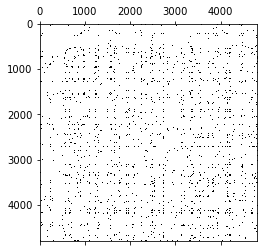

In [115]:
plt.spy(weight)
plt.show()